# In sample portfolio strategies


### Import CLA and define getCLA 

The CLA algorithm is borrowed from Prado and Bailey (2013)'s open source implementation

In [40]:
from importlib import reload

In [41]:
import scipy.cluster.hierarchy as sch,random,numpy as np,pandas as pd, CLA

def getCLA(cov,**kargs):
    # Compute CLA's minimum variance portfolio
    mean=np.arange(cov.shape[0]).reshape(-1,1) # Not used by C portf
    lB=np.zeros(mean.shape)
    uB=np.ones(mean.shape)
    cla=CLA.CLA(mean,cov,lB,uB)
    cla.solve()
    return cla.w[-1].flatten()

### Prepare Gurobi solver to solve QP

In [9]:
from gurobipy import *
def QPsol(cov,**kargs):
    m = Model()
    # Create one variable for each stock
    portvars = [m.addVar(name=str(i),lb=0.0,ub=1.0) for i in range(1, cov.shape[0]+1)]
    portvars = pd.Series(portvars, index=range(1, cov.shape[0]+1))
    portfolio = pd.DataFrame({'Variables':portvars})
    
    m.update()

    # The total budget
    p_total = portvars.sum()

    # The mean return for the portfolio
    #p_return = stats['Mean_return'].dot(portvars)
    # The (squared) volatility of the portfolio
    #print cov
    p_risk = np.transpose(portvars).dot(cov).dot(portvars)
    # Commit the changes to the model
    m.update()

    # Set the objective: minimize risk
    m.setObjective(p_risk, GRB.MINIMIZE)

    # Fix the budget
    m.addConstr(p_total, GRB.EQUAL, 1)

    # Turn off the output
    m.params.OutputFlag = 0
    # Select a simplex algorithm (to ensure a vertex solution)
    m.setParam('Method', 1)  
    m.optimize()
    m.update()


    # Get the optimal portfolio weights for zero return portfolio.
    w = portvars.apply(lambda x:x.getAttr('x'))
    return w

### Hierarchical Risk Parity Algorithm
The algorithm is implemented as it is described in the paper


In [21]:
# Hierarchical Risk Parity
#matplotlib inline
import matplotlib.pyplot as mpl
import scipy.cluster.hierarchy as sch,random,numpy as np,pandas as pd
#------------------------------------------------------------------------------
def getIVP(cov,**kargs):
    # Compute the inverse-variance portfolio
    ivp=1./np.diag(cov)
    ivp/=ivp.sum()
    return ivp
#------------------------------------------------------------------------------
def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar
#------------------------------------------------------------------------------
def getQuasiDiag(link):
    # Sort clustered items by distance
    link=link.astype(int)
    sortIx=pd.Series([link[-1,0],link[-1,1]])
    numItems=link[-1,3] # number of original items
    while sortIx.max()>=numItems:
        sortIx.index=range(0,sortIx.shape[0]*2,2) # make space
        df0=sortIx[sortIx>=numItems] # find clusters
        i=df0.index;j=df0.values-numItems
        sortIx[i]=link[j,0] # item 1
        df0=pd.Series(link[j,1],index=i+1)
        sortIx=sortIx.append(df0) # item 2
        sortIx=sortIx.sort_index() # re-sort
        sortIx.index=range(sortIx.shape[0]) # re-index
    return sortIx.tolist()
#------------------------------------------------------------------------------
def getRecBipart(cov,sortIx):
    # Compute HRP alloc
    w=pd.Series(1,index=sortIx)
    cItems=[sortIx] # initialize all items in one cluster
    while len(cItems)>0:
        cItems=[i[j:k] for i in cItems for j,k in ((0,round(len(i)/2)), (round(len(i)/2),len(i))) if len(i)>1] # bi-section
        for i in range(0,len(cItems),2): # parse in pairs
            #print cItems
            cItems0=cItems[i] # cluster 1
            #print "cItems0",cItems0
            cItems1=cItems[i+1] # cluster 2
            cVar0=getClusterVar(cov,cItems0)
            cVar1=getClusterVar(cov,cItems1)
            alpha=1-cVar0/(cVar0+cVar1)
            w[cItems0]*=alpha # weight 1
            w[cItems1]*=1-alpha # weight 2
    return w
#------------------------------------------------------------------------------
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist=(2*(1-corr))**.5 # distance matrix
    return dist


#------------------------------------------------------------------------------
def plotCorrMatrix(path,corr,labels=None):
    # Heatmap of the correlation matrix
    if labels is None:labels=[]
    mpl.pcolor(corr)
    mpl.colorbar()
    mpl.yticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.xticks(np.arange(.5,corr.shape[0]+.5),labels)
    #mpl.savefig(path)
    #mpl.clf();
    #mpl.close() # reset pylab
    mpl.show()
    mpl.close()
    return
#------------------------------------------------------------------------------



### In sample results

In [ ]:
def generateData(nObs,size0,size1,sigma1):
    # Time series of correlated variables
    #1) generating some uncorrelated data
    np.random.seed(seed=12345);random.seed(12345)
    x=np.random.normal(0,1,size=(nObs,size0)) # each row is a variable
    #print "Correlations",np.corrcoef(x)
    #2) creating correlation between the variables
    cols=[random.randint(0,size0-1) for i in range(size1)]
    #print cols
    # Add mild and strong correlations between the assets-2
    y=x[:,cols]+np.random.normal(0,sigma1,size=(nObs,len(cols)))
    #y=x[:,cols]+np.random.normal(0,sigma1,size=(nObs,len(cols)))
    x=np.append(x,y,axis=1)
    x=pd.DataFrame(x,columns=range(1,x.shape[1]+1))
    return x,cols

In [57]:
reload(CLA)

<module 'CLA' from '/home/ubuntu/notebook/RiskParity/CLA.py'>

1     0.960407
2     1.001069
3     0.992179
4     1.031637
5     0.988017
6     1.055300
7     0.979578
8     1.022091
9     1.020384
10    1.018361
dtype: float64
          1         2         3         4         5         6         7   \
1   1.000000 -0.038233 -0.031407  0.014190  0.008599  0.020826  0.967417   
2  -0.038233  1.000000 -0.028351  0.031914 -0.030051  0.035024 -0.053394   
3  -0.031407 -0.028351  1.000000 -0.029119  0.022387 -0.032061 -0.025562   
4   0.014190  0.031914 -0.029119  1.000000 -0.038948  0.969197  0.010280   
5   0.008599 -0.030051  0.022387 -0.038948  1.000000 -0.022382  0.003445   
6   0.020826  0.035024 -0.032061  0.969197 -0.022382  1.000000  0.017415   
7   0.967417 -0.053394 -0.025562  0.010280  0.003445  0.017415  1.000000   
8  -0.034293 -0.022853  0.970866 -0.035098  0.020734 -0.037046 -0.027581   
9  -0.023258 -0.026937  0.969739 -0.026222  0.022399 -0.030702 -0.015085   
10 -0.022718  0.969529 -0.031486  0.032490 -0.026804  0.034553 -0.041416   

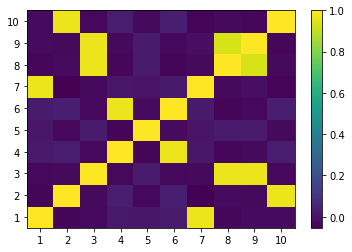

[[  1.           9.           0.34942691   2.        ]
 [  3.           5.           0.35130495   2.        ]
 [  2.           7.           0.35788034   2.        ]
 [  0.           6.           0.36153842   2.        ]
 [  8.          12.           0.36554134   3.        ]
 [  4.          13.           2.30422362   3.        ]
 [ 11.          15.           2.34993308   5.        ]
 [ 10.          16.           2.35144249   7.        ]
 [ 14.          17.           2.51670937  10.        ]]


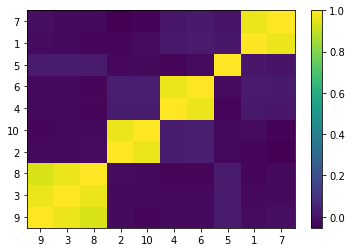

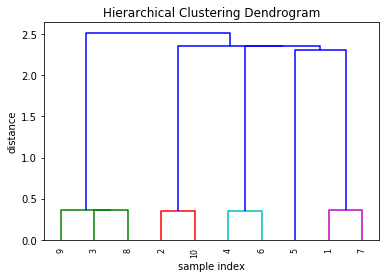

GurobiError: No Gurobi license found (user ubuntu, host ip-172-31-1-219, hostid 9d704ccf)

In [58]:
#------------------------------------------------------------------------------
# def main():
#1) Generate correlated data
nObs,size0,size1,sigma1=1000,5,5,.25
x,cols=generateData(nObs,size0,size1,sigma1)
#print x.dtypes
#print [(j+1,size0+i) for i,j in enumerate(cols,1)]
#2) compute and plot correl matrix
#print x.shape
#B=covNYSE10
#B=pd.DataFrame(B)
cov,corr,std=x.cov(),x.corr(),x.std()
print(std)
std_diag = np.diag(std)
print(corr)
#cov = corr.dot(std_diag).dot(std_diag)
#corr=B
#print corr
covCLA = cov.values
corrCLA = corr.values
print('cov',len(np.unique(cov)))
print('corr',len(np.unique(corr)))   
#print covCLA
plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns)
#3) cluster
dist=correlDist(corr)
#print dist
link=sch.linkage(dist,'single')
print(link)
sortIx=getQuasiDiag(link)
sortIx=corr.index[sortIx].tolist() # recover labels
df0=corr.loc[sortIx,sortIx] # reorder
cov_hrp=cov.loc[sortIx,sortIx] # reorder
plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
#4) Capital allocation
# calculate full dendrogram
mpl.figure()
mpl.title('Hierarchical Clustering Dendrogram')
mpl.xlabel('sample index')
mpl.ylabel('distance')
sch.dendrogram(
link,
labels=corr.index.tolist(),
leaf_rotation=90.,  # rotates the x axis labels
leaf_font_size=8.,  # font size for the x axis labels
)
mpl.show()
hrp=getRecBipart(cov,sortIx)
w_=getIVP(cov)
wIVP = pd.Series(w_,index = range(1,11))
wCLA = pd.Series(getCLA(covCLA),index = range(1,11))
wCLA.reset_index()
qw = QPsol(covCLA)
result = pd.concat([hrp, wIVP, wCLA, qw], axis=1, join_axes=[wIVP.index])
result.columns=['HRP','IVP','CLA','QP']
riskIVP = cov.dot(wIVP).dot(wIVP)
riskhrp = cov_hrp.dot(hrp).dot(hrp)
riskCLA = cov.dot(wCLA).dot(wCLA)
riskqw = cov.dot(qw).dot(qw)
liste = [riskhrp, riskIVP, riskCLA, riskqw]
risk_result = pd.DataFrame(liste).transpose()
risk_result.columns=['HRP','IVP','CLA','QP']

print("Portfolio weights\n", result,"\n")
print("Portfolio risk\n", risk_result)
#     return result

#------------------------------------------------------------------------------